**Loan Delinquency Prediction**

Loan default prediction is one of the most critical and crucial problem faced by financial institutions and organizations as it has a noteworthy effect on the profitability of these institutions. In recent years, there is a tremendous increase in the volume of non – performing loans which results in a jeopardizing effect on the growth of these institutions.
 
Therefore, to maintain a healthy portfolio, the banks put stringent monitoring and evaluation measures in place to ensure timely repayment of loans by borrowers. Despite these measures, a major proportion of loans become delinquent. Delinquency occurs when a borrower misses a payment against his/her loan.
 
Given the information like:
- mortgage details, borrowers related details and payment details, 

**Our objective is to identify the delinquency status of loans for the next month given the delinquency status for the previous 12 months (in number of months)**

# Data Dictionary
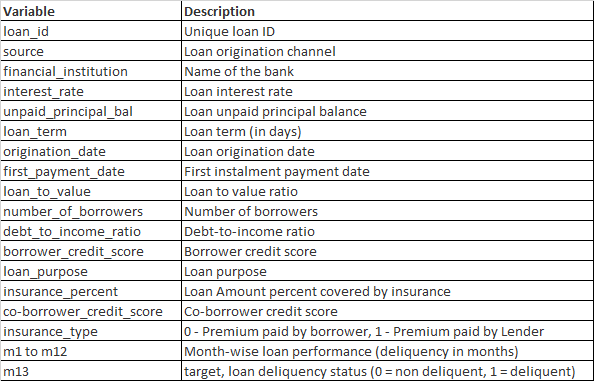

In [2]:
import keras
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,imputation,StandardScaler,MinMaxScaler,Binarizer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,classification,f1_score,confusion_matrix
from sklearn.preprocessing.imputation import Imputer
from category_encoders.one_hot import OneHotEncoder,OrdinalEncoder

Using TensorFlow backend.


In [117]:
print("Numpy Version")
print(np.__version__)
print("Keras Version")
print(keras.__version__)
import tensorflow as tf
print("Tensor Version")
tf.__version__
%matplotlib inline

Numpy Version
1.16.4
Keras Version
2.2.4
Tensor Version


In [161]:
# loading the dataset
df = pd.read_csv('train.csv',
                 parse_dates = True,
                 infer_datetime_format = True,
                 na_values = ['',' ','[]','-','?'],
                 encoding='utf-8') #.head()

In [237]:
df.head()
pd.set_option('display.max_columns',50)
df.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.000,22.000,694.000,C86,30.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1
1,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.000,44.000,697.000,B12,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,1,0,1
2,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.000,33.000,780.000,B12,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,1
3,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.000,44.000,633.000,B12,0.000,638.000,0.000,0,0,0,0,0,0,0,0,1,1,1,1,1
4,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.000,43.000,681.000,C86,0.000,0.000,0.000,0,1,2,3,4,5,6,7,8,9,10,11,1


In [ ]:
time,
distance
speed = 

# Data Cleaning and checking 

In [268]:
df.isna().sum() # no NAs Found

source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
m13                         0
dtype: int64

# Exploratory Data Analysis

In [167]:
def count_plt(df,col,hue,title=None):
    ax = sns.countplot(x= col,
                       data=df,
                       hue = hue,
                       order = df[col].value_counts().index.to_list())

    total = df.shape[0]  # total number of rows in the dataset
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x()+p.get_width()/2.,
                y=height, 
                s= '{:1.2f}%'.format(height/total*100), 
                ha="center" )
    plt.title(title)

Loans borrowed in the month of April and March are significantly delinquient

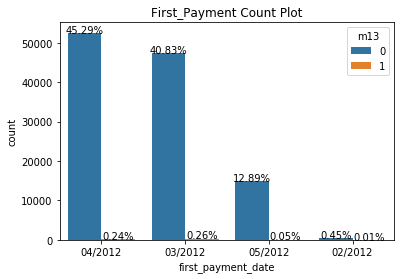

In [168]:
count_plt(df=df,col='first_payment_date',hue='m13',title='First_Payment Count Plot')
plt.show()

In [169]:
print('Duplicates in the loan_id are:',df.loan_id.duplicated().sum()) 
df.drop(columns=['loan_id'],axis=1,inplace=True)

Duplicates in the loan are: 0


All loan ids are unique. Hence can be dropped out. 

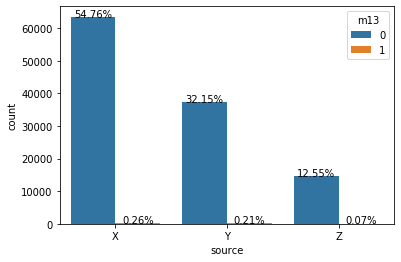

In [170]:
count_plt(df=df,col='source',hue='m13')
plt.show()

A Large number of loans have originated from X. Most of the loans from this source are delinquent 

In [173]:
df.select_dtypes(include='object').columns.to_list()

['source',
 'financial_institution',
 'origination_date',
 'first_payment_date',
 'loan_purpose']

In [174]:
df_rand = df.sample(n=1000,axis=0,random_state=10)

In [272]:
# new_cols = ['source', 'fin_inst', 'int_rate',
#        'unpd_prin_bal', 'loan_term', 'orig_dt',
#        '1st_pymnt_dt', 'loan2val', 'no_borwrs',
#        'debt2inc', 'brwr_cred_scr', 'loan_prp',
#        'insrn_prcnt', 'co_brwr_cred_scr', 'insrn_typ', 'm1',
#        'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12','m13']

# col_dic = {}

# for i,name in enumerate(df.coluamns):
#     col_dic[name] = new_cols[i]
    

# df.rename(mapper= col_dic ,axis=1)

In [234]:
# df.financial_institution.value_counts() # .describe() 
# plt.bar()
df.pivot_table(index='origination_date',columns='financial_institution',values='unpaid_principal_bal',aggfunc='mean') # .plot(kind='bar')

financial_institution,Anderson-Taylor,Browning-Hart,Chapman-Mcmahon,"Cole, Brooks and Vincent",Edwards-Hoffman,"Martinez, Duffy and Bird","Miller, Mcclure and Allen",Nicholson Group,OTHER,Richards-Walters,Richardson Ltd,"Romero, Woods and Johnson","Sanchez, Hays and Wilkerson",Sanchez-Robinson,Suarez Inc,"Swanson, Newton and Miller","Taylor, Hunt and Rodriguez",Thornton-Davis,"Turner, Baldwin and Rhodes"
origination_date,,,,,,,,,,,,,,,,,,,
2012-01-01,186591.479,217891.725,245607.143,199304.591,228283.457,191065.900,212858.429,230522.544,188217.416,214311.404,166918.803,183955.631,264010.309,131988.406,223142.702,218927.313,223168.576,219777.202,174593.509
2012-02-01,190654.762,229119.486,263208.633,203983.655,231448.131,200592.593,216561.392,237820.856,195713.196,230858.631,174058.824,171070.732,289837.017,143390.625,215989.597,224308.969,231263.048,221523.636,199493.236
2012-03-01,nan,281620.155,250938.272,202605.263,242352.601,207738.506,215131.915,183746.032,194130.534,249199.396,30000.000,180042.553,264707.071,135507.500,253912.621,232097.691,224414.201,225404.372,217436.975


In [ ]:
df.financial_institution.astype('category').cat.categories

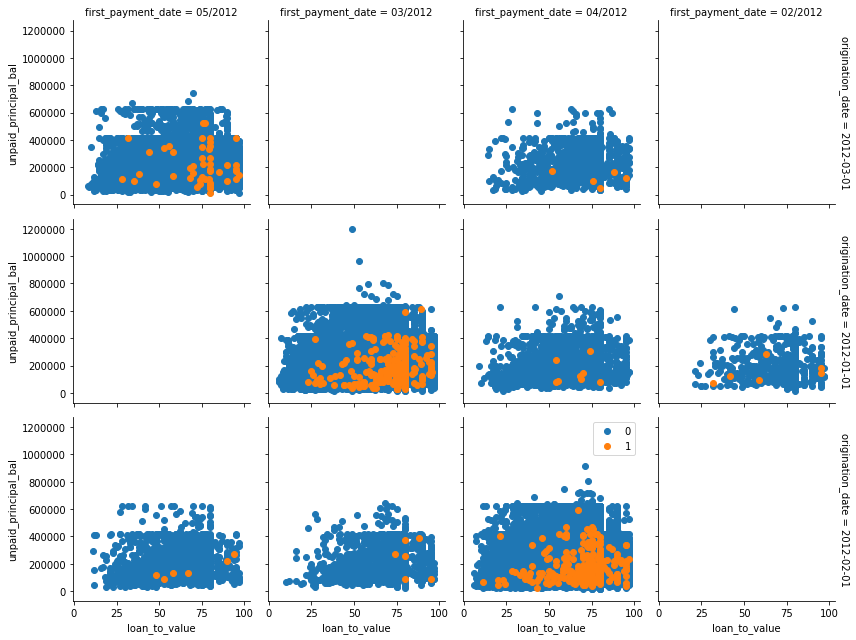

In [209]:
g = sns.FacetGrid(data = df,col='first_payment_date',row='origination_date',hue='m13',
                  legend_out=True,
                  margin_titles=True,
                  hue_order= df_rand['m13'].value_counts().index.to_list()
                 )
g.map(plt.scatter,'loan_to_value','unpaid_principal_bal',)
plt.legend()
plt.show()

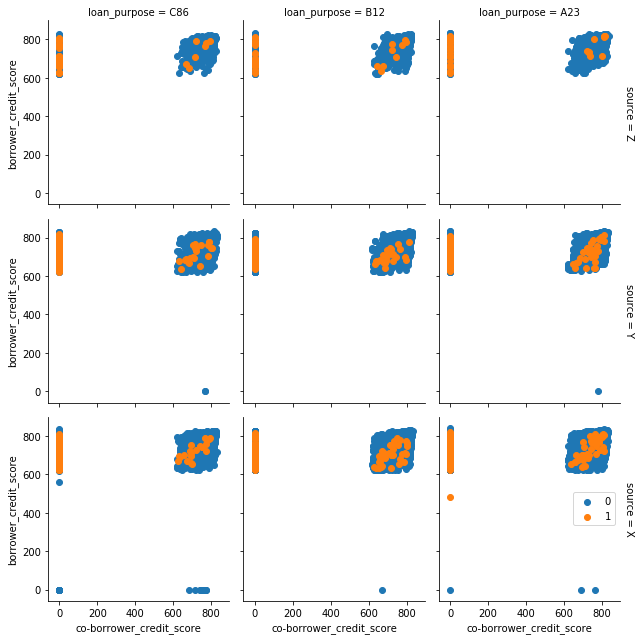

In [210]:
g = sns.FacetGrid(data = df,col='loan_purpose',row='source',hue='m13',
                  legend_out=True,
                  margin_titles=True,
                  hue_order= df_rand['m13'].value_counts().index.to_list()
                 )
g.map(plt.scatter,'co-borrower_credit_score','borrower_credit_score',)
plt.legend()
plt.show()

In [211]:
df.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')

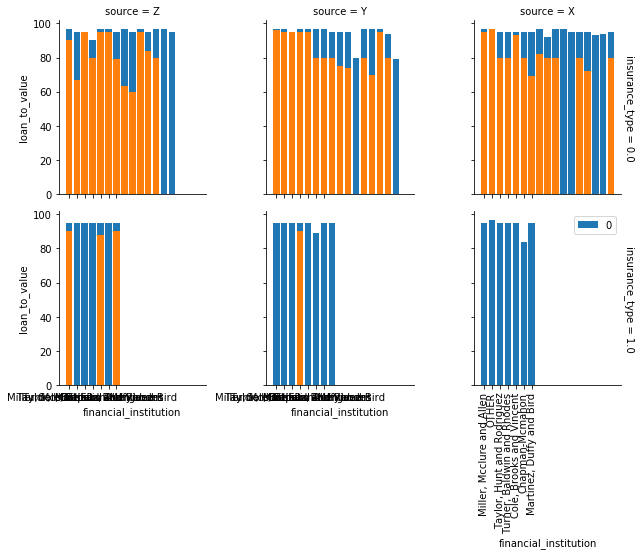

In [218]:
g = sns.FacetGrid(data = df,row='insurance_type',col='source',hue='m13',
                  legend_out=True,
                  margin_titles=True,
                  hue_order= df_rand['m13'].value_counts().index.to_list()
                 )
g.map(plt.bar,'financial_institution','loan_to_value',)
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

Insurance type 0, where insurance paid by the borrower has most number cases of delinquency. It can also be observed that Financial institution other most number of 

In [266]:
# df.pivot_table(index='financial_institution',columns='m13',values='loan_to_value')
# sns.heatmap()

In [267]:
fin_grpby = df.groupby(by=['source','m13'],axis=0,)
fin_grpby.first()

financial_institution  interest_rate  unpaid_principal_bal  \
source m13                                                                    
X      0      Martinez, Duffy and Bird          3.375                305000   
       1                         OTHER          4.750                135000   
Y      0                 Browning-Hart          3.875                198000   
       1    Swanson, Newton and Miller          4.875                144000   
Z      0               Edwards-Hoffman          4.500                120000   
       1    Turner, Baldwin and Rhodes          4.250                214000   

            loan_term origination_date first_payment_date  loan_to_value  \
source m13                                                                 
X      0          180       2012-02-01            04/2012             52   
       1          360       2012-02-01            04/2012             46   
Y      0          360       2012-01-01            04/2012             51   
       1          360       2012-01-01            03/2012             72   
Z      0          360       2012-01-01            03/2012             71   
       1          360       2012-03-01            05/2012             95   

            number_of_borrowers  debt_to_income_ratio  borrower_credit_score  \
source m13                                                                     
X      0                  2.000                32.000                811.000   
       1                  2.000                44.000                633.000   
Y      0                  2.000                23.000                812.000   
       1                  1.000                44.000                697.000   
Z      0                  2.000                39.000                752.000   
       1                  1.000                22.000                694.000   

           loan_purpose  insurance_percent  co-borrower_credit_score  \
source m13                                                             
X      0            A23              0.000                   809.000   
       1            B12              0.000                   638.000   
Y      0            A23              0.000                   790.000   
       1            B12              0.000                     0.000   
Z      0            C86              0.000                   740.000   
       1            C86             30.000                     0.000   

            insurance_type  m1  m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12  
source m13                                                                     
X      0             0.000   0   0   0   0   0   0   0   0   0    0    0    0  
       1             0.000   0   0   0   0   0   0   0   0   1    1    1    1  
Y      0             0.000   0   0   0   0   0   0   0   0   0    0    0    0  
       1             0.000   0   0   0   0   0   0   0   0   0    0    1    0  
Z      0             0.000   0   0   0   0   0   0   0   0   0    0    0    0  
       1             0.000   0   0   0   0   0   0   1   0   0    0    0    0

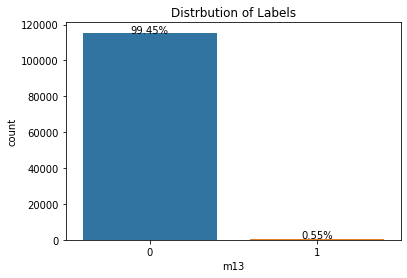

In [277]:
# Find the distribution of Target Variable
count_plt(df=df,col='m13',hue=None,title="Distrbution of Labels")

Just **0.55%** percent of data is delinquent. We have identify the factors that led to the delinquency

In [486]:
df_rand.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
14738,3.250,122000,180,14,2.000,27.000,749.000,0.000,801.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0
98008,3.350,120000,180,71,2.000,45.000,796.000,0.000,802.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0
77382,3.375,102000,180,63,1.000,33.000,790.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0
35002,5.000,120000,360,75,1.000,29.000,763.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0
58663,3.750,110000,360,75,1.000,49.000,778.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0


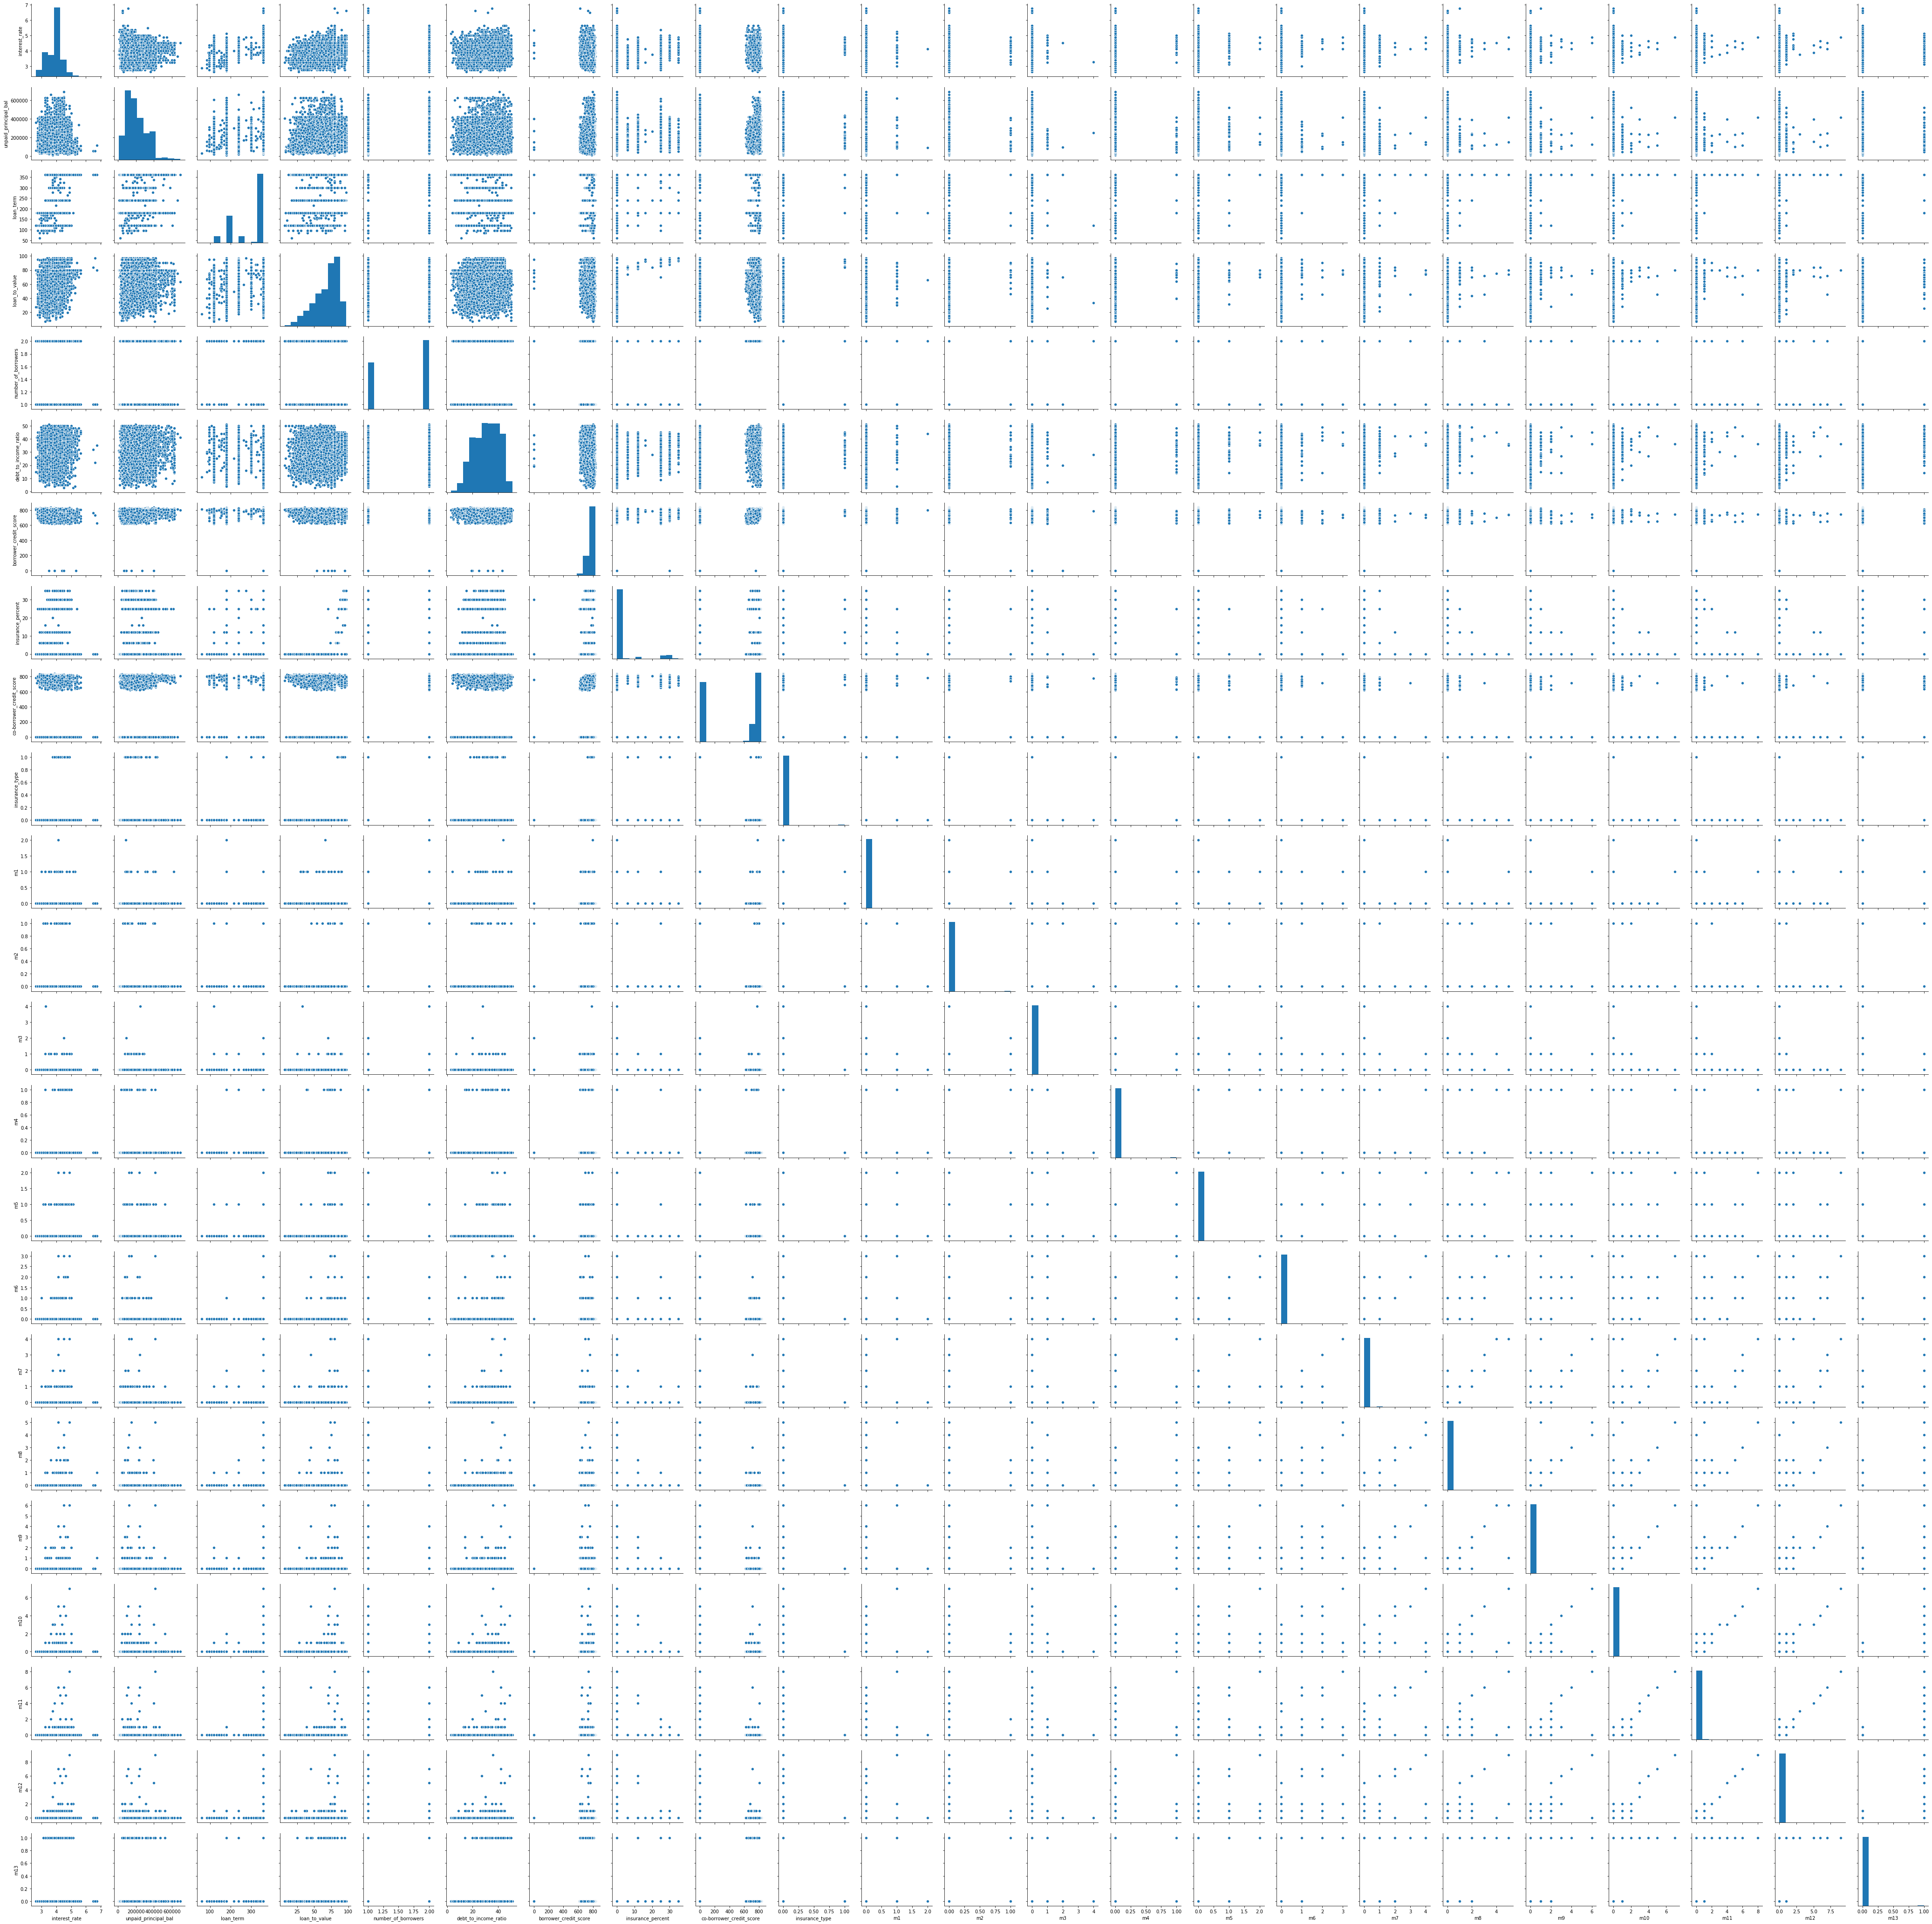

In [485]:
# Check the distribution of continuous variables. 
df_rand = df.select_dtypes(include=['int64','float64']).sample(n=10000,random_state=10,axis=0)
# df.sample()

df_rand.head()

sns.pairplot(df_rand)

In [502]:
df_rand.corr()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
interest_rate,1.000,-0.015,0.717,0.274,-0.135,0.175,-0.198,0.131,-0.144,0.050,0.011,0.016,0.021,0.042,0.051,0.055,0.045,0.058,0.056,0.050,0.047,0.052,0.057
unpaid_principal_bal,-0.015,1.000,0.184,0.068,0.131,0.091,0.057,0.013,0.134,0.013,0.010,-0.012,-0.010,-0.012,0.006,-0.009,-0.007,-0.006,-0.006,0.005,0.003,0.006,0.002
loan_term,0.717,0.184,1.000,0.297,-0.110,0.142,-0.061,0.185,-0.113,0.032,-0.006,0.013,-0.008,0.018,0.025,0.032,0.024,0.032,0.024,0.029,0.030,0.029,0.032
loan_to_value,0.274,0.068,0.297,1.000,-0.095,0.139,-0.128,0.484,-0.103,0.070,-0.005,0.019,-0.005,0.012,0.023,0.019,0.014,0.012,0.009,0.017,0.015,0.010,0.019
number_of_borrowers,-0.135,0.131,-0.110,-0.095,1.000,-0.127,0.113,-0.039,0.996,-0.034,-0.007,-0.016,-0.014,-0.020,-0.036,-0.038,-0.035,-0.044,-0.038,-0.029,-0.032,-0.030,-0.045
debt_to_income_ratio,0.175,0.091,0.142,0.139,-0.127,1.000,-0.176,0.075,-0.137,0.009,0.012,-0.000,0.003,0.008,0.027,0.023,0.030,0.028,0.024,0.028,0.028,0.029,0.046
borrower_credit_score,-0.198,0.057,-0.061,-0.128,0.113,-0.176,1.000,-0.057,0.154,0.004,-0.019,-0.052,-0.092,-0.056,-0.068,-0.071,-0.063,-0.070,-0.079,-0.064,-0.062,-0.063,-0.096
insurance_percent,0.131,0.013,0.185,0.484,-0.039,0.075,-0.057,1.000,-0.044,0.140,0.001,-0.001,-0.006,-0.009,-0.001,0.005,-0.005,-0.011,-0.007,-0.001,0.002,-0.001,-0.004
co-borrower_credit_score,-0.144,0.134,-0.113,-0.103,0.996,-0.137,0.154,-0.044,1.000,-0.034,-0.007,-0.016,-0.015,-0.022,-0.038,-0.039,-0.037,-0.046,-0.040,-0.031,-0.034,-0.032,-0.047
insurance_type,0.050,0.013,0.032,0.070,-0.034,0.009,0.004,0.140,-0.034,1.000,0.037,-0.002,-0.002,-0.002,-0.003,-0.003,-0.003,-0.003,-0.003,-0.003,-0.002,-0.003,-0.004


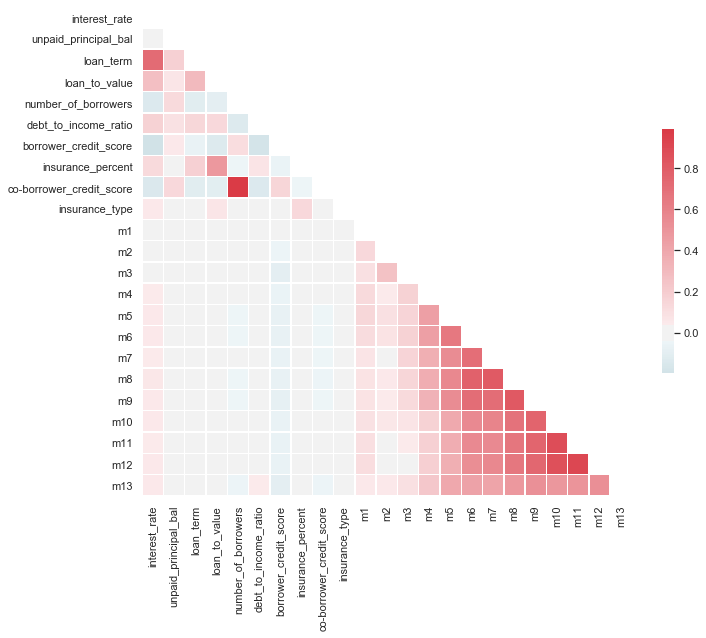

In [500]:
# from string import ascii_letters
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df_rand.copy()

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # upper triangle to 1 to mask out the colors wi

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

 - Months m5-m12 show strong correlation among themselves. These variables do not seam to have any correlation with the other set of continuous variables.
 - debt_to_income_ratio and the co-borrower score show some strong correaltion
 - loan_term and interest_rate percent. 
 - loan_to_value and insurance percent are the variables that show good correaltion among themselves.

In [528]:
data.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')

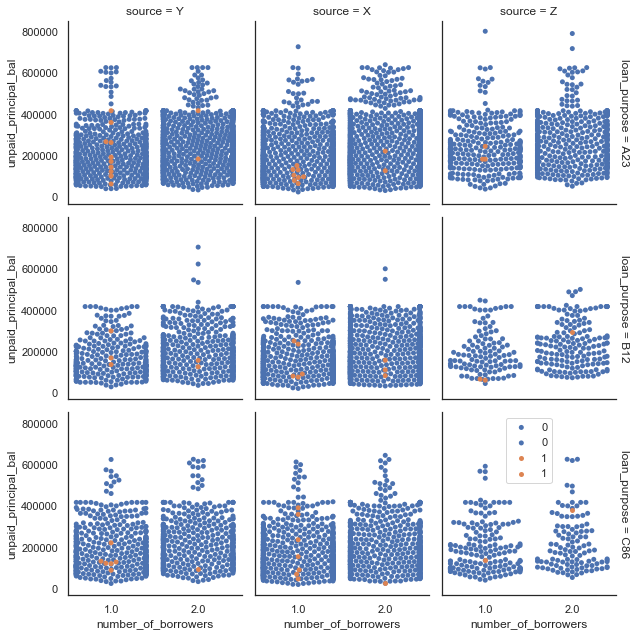

In [537]:
data = df.sample(10000,random_state=100)
g = sns.FacetGrid(data = data,
                  col='source',
                  row='loan_purpose',hue='m13',
                  legend_out=True,
                  margin_titles=True,
                  hue_order= data['m13'].value_counts().index.to_list()
                 )
g.map(sns.swarmplot,'number_of_borrowers','unpaid_principal_bal')
plt.legend()
plt.show()

Across the sources, and with one co_borrower there is more delinquency in the data

# OneHot Encoding of data

In [452]:
def cat_conv(df,col, encoder = 'label'):
    '''
    encoder : default is label_enconder, for ordinal_encoder, choose 'None'
    '''
    
    # For label Encoder
    if encoder == 'label': 
        df.financial_institution = df.financial_institution.astype('category')
        cols = df.select_dtypes(include='object').columns.to_list()

        # Instantiate Label Encoder
        enc = OneHotEncoder(cols=cols,drop_invariant=True,use_cat_names=True)

        # Fit and transform
        enc_fit = enc.fit(df.select_dtypes(include='object'))
        X = df[cols]
        df_one_hot_trnsfm = enc_fit.transform(X=X)
        df_one_hot_inv_trnsfm = enc_fit.inverse_transform(X_in=df_one_hot_trnsfm)
        
        return df_one_hot_trnsfm, df_one_hot_inv_trnsfm

    else:
        df.financial_institution = df.financial_institution.astype('object')
        
        # Creating a mapping of categories by order of value counts
        bucket_categories = df[col].value_counts().index.tolist()
        X_map = [(cat,i+1) for i,cat in enumerate((bucket_categories))]
        mapping=[{'col': col, 'mapping': X_map}]

        # Instantiating the Ordinal Encoder
        encoder = OrdinalEncoder(cols=[col],mapping= mapping,drop_invariant=True)
        X = df[[col]]
        print(X.dtypes)

        # Fit and Transform the ordinal Encoder
        enc_fit = encoder.fit(X)
        enc_trnsfm = enc_fit.transform(X)
        enc_invtrnsfm = enc_fit.inverse_transform(X_in=enc_trnsfm)
        return enc_trnsfm,enc_invtrnsfm

In [587]:
print()
# Categorical_encoding of 
financial_institution = cat_conv(df=df,col='financial_institution',encoder=None)[0]
financial_institution.head(2)


financial_institution    object
dtype: object


,financial_institution
0,8
1,3


In [588]:
one_hot = cat_conv(df=df,col=None,encoder='label')[0]
one_hot.head(3)

,source_Z,source_Y,source_X,origination_date_2012-03-01,origination_date_2012-01-01,origination_date_2012-02-01,first_payment_date_05/2012,first_payment_date_03/2012,first_payment_date_04/2012,first_payment_date_02/2012,loan_purpose_C86,loan_purpose_B12,loan_purpose_A23
0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,0,1,0,0,1,0,0,1,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,1,0


In [589]:
df.select_dtypes(exclude=['object','category']).head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,4.250,214000,360,95,1.000,22.000,694.000,30.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1
1,4.875,144000,360,72,1.000,44.000,697.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,1,0,1
2,3.250,366000,180,49,1.000,33.000,780.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4.750,135000,360,46,2.000,44.000,633.000,0.000,638.000,0.000,0,0,0,0,0,0,0,0,1,1,1,1,1
4,4.750,124000,360,80,1.000,43.000,681.000,0.000,0.000,0.000,0,1,2,3,4,5,6,7,8,9,10,11,1


In [687]:
temp_df = pd.concat(objs=[one_hot,financial_institution,df.select_dtypes(exclude=['object','category'])],axis=1) #.head()
X = temp_df.iloc[:,:-1]
y = temp_df['m13']

# Scaling the dataset X 

In [688]:
# instantiating the standard scaler 
sclr = StandardScaler()

# fit and transform
sclr_fit = sclr.fit(X)
sclr_trnsfm = sclr_fit.transform(X)
sclr_trnsfm_df = pd.DataFrame(sclr_trnsfm,columns=X.columns)

# X = sclr_trnsfm_df.copy()

# Smoting the dataset to balance target label

In [689]:
#Smoting the Dataset to distribute 
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote_smpler = SMOTE(random_state=10,n_jobs=4)

# fit and transform the dataset
smote_fit = smote_smpler.fit_sample(X=sclr_trnsfm_df,y=y)
X = pd.DataFrame(smote_fit[0],columns=sclr_trnsfm_df.columns)
y = pd.DataFrame(smote_fit[1],columns=['m13'])

In [694]:
print(X.shape)
print(y.m13.value_counts())

(230844, 36)
1    115422
0    115422
Name: m13, dtype: int64


# Splitting the Dataset into train and test

In [695]:
# Remove Special Characters from the column headers of test_Dataset
X.columns = X.columns.str.replace("[-/]","_")

X.columns

In [697]:
# Splitting the dataset in to Train and Validation sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.333, random_state = 10,stratify=y)
print('Xtrain:\t',X_train.shape,'\nX_test:\t',X_test.shape,'\ny_train:',y_train.shape,'\ny_test:\t',y_test.shape)

# Model Building

In [422]:
# df.financial_institution = df.financial_institution.astype('object')

# cols = df.select_dtypes(include='object').columns.to_list()
# cols

# enc = OneHotEncoder(cols=cols,drop_invariant=True,use_cat_names=True)

# enc_fit = enc.fit(df.select_dtypes(include='object'))

# df_one_hot = enc_fit.transform(df[cols])

# # get list of categories
# val_cnts = df.financial_institution.value_counts() #.index.to_list()
# # tuple of category and index
# tpl_cat = [(cat,i+1)  for i,cat in enumerate(val_cnts.index.to_list())]

# tpl_cat

# k = df.financial_institution.value_counts()
# k
# mapping =  [{'col':k.name, 'mapping':  tpl_cat}]

# mapping